# **Preprocessing of the UW Madison GI Tract Dataset**

The [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/) dataset was introduced in 2022 on the [Kaggle](https://www.kaggle.com/) platform as part of a medical image segmentation challenge. The dataset consists of grayscale medical images of the gastrointestinal tract, specifically focusing on the **stomach**, **large bowel**, and **small bowel**.  

The publicly available dataset contains **16,590** PNG images along with their corresponding segmentation masks encoded in **Run-Length Encoding (RLE)**. However, the test set is not publicly available. Therefore, the publicly available dataset is typically split randomly into **80% for training and 20% for validation**.

## **Imports**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm.auto import tqdm
from google.colab import drive
import cv2
import os

## **Parameters**

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
dataset_url = os.path.basename("https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation")
raw_dataset_dir = "/content/Raw_UW-Madison-GI-Tract"
dataset_dir = "/content/UW-Madison-GI-Tract"
zip_dataset_path = "/content/drive/MyDrive/Datasets/UW-Madison-GI-Tract.zip"
val_size = 0.2
SEED = 123

## **Download and Extract the Dataset**

The dataset is available on the official [Kaggle](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/) website. To download it, you need to create a Kaggle account and obtain the `kaggle.json` file, which contains your API credentials. This file must then be uploaded to Google Colab or your chosen working environment to access the dataset using the Kaggle API.

In [4]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the dataset
!kaggle competitions download -c $dataset_url

100% 2.29G/2.30G [00:20<00:00, 162MB/s]
100% 2.30G/2.30G [00:20<00:00, 122MB/s]


In [7]:
# Unzip the dataset
!unzip -q {dataset_url + ".zip"} -d $raw_dataset_dir

## **Preprocess the Dataset**

In [8]:
# Load the CSV file into a DataFrame and remove null rows
df = pd.read_csv(os.path.join(raw_dataset_dir, "train.csv"))
df = df.dropna().reset_index(drop=True)
df

,id,class,segmentation
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...
...,...,...,...
33908,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...
33909,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...
33910,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...
33911,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...


In [9]:
raw_dataset_dir = os.path.join(raw_dataset_dir, "train")

# Number of patient cases
len(os.listdir(raw_dataset_dir))

85

In [10]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
dtypes: object(3)
memory usage: 795.0+ KB


In [11]:
# Number of annotations per class
df["class"].value_counts()

,count
class,
large_bowel,14085
small_bowel,11201
stomach,8627


In [12]:
# Get all unique file names
filenames = df.id.unique()
print(len(filenames))

# Get the class names
class_names = ["background"] + df["class"].unique().tolist()
class_names

16590


['background', 'stomach', 'large_bowel', 'small_bowel']

In [13]:
# Create the image and mask directories
image_dir = os.path.join(dataset_dir, "images")
mask_dir = os.path.join(dataset_dir, "masks")

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

In [14]:
# Function to find the image path corresponding to a filename
def get_image_path(filename, data_dir):
  case_name, day, slice_name = filename.split("_", 2)
  image_path = os.path.join(data_dir, case_name, f"{case_name}_{day}", "scans")
  basename = next((name for name in os.listdir(image_path) if slice_name in name), None)

  if basename is None:
    raise FileNotFoundError(f"The image for {filename} was not found")

  return os.path.join(image_path, basename)

 Image preprocessing involves iterating over all unique file names (IDs), then finding their path, loading the image for normalization, and converting it to the `uint8` type, as it is originally in `uint16` with pixel values greater than 255. Finally, the normalized image is saved in the image directory.

In [15]:
for filename in tqdm(filenames):
  # Find the image path
  image_path = get_image_path(filename, raw_dataset_dir)

  # Load the image
  image = np.array(Image.open(image_path))
  
  # Normalize the image and convert it to 'uint8' type
  image = (image - image.min()) / (image.max() - image.min())
  image = (image * 255).astype(np.uint8)
  image = Image.fromarray(image)
  
  # Save the preprocessed image
  image.save(os.path.join(image_dir, f"{filename}.png"))

  0%|          | 0/16590 [00:00<?, ?it/s]

To generate the segmentation masks, each image path is iterated over, and the DataFrame is filtered by filename to obtain only the annotations corresponding to a specific image. Then, an array of zeros is created with the dimensions of the given image, and for each annotation, the RLE-encoded mask is decoded to fill the zero mask with the class value corresponding to the row. Finally, the preprocessed mask is saved in the mask directory.

In [16]:
# Get the paths of all images
image_paths = sorted(glob(os.path.join(image_dir, "*.png")))

for path in tqdm(image_paths):
  # Find the dimensions and name of the image
  width, height = Image.open(path).size
  filename = os.path.basename(path).split(".")[0]
  
  # Filter the DataFrame and create the zero mask
  df_file = df[df.id == filename]
  mask = np.zeros((height * width,), dtype=np.uint8)

  for _, row in df_file.iterrows():
    # Get the class index
    cls = class_names.index(row["class"])

    # Get the RLE-encoded mask
    segment = list(map(int, row["segmentation"].split()))
    starts, lengths = segment[0::2], segment[1::2]
    
    # Fill the zero mask with the class index
    for start, length in zip(starts, lengths):
      mask[start: start + length] = cls
  
  # Resize the mask to the image dimensions
  mask = mask.reshape((height, width))
  mask = Image.fromarray(mask)
  
  # Save the preprocessed mask
  mask.save(os.path.join(mask_dir, f"{filename}.png"))

  0%|          | 0/16590 [00:00<?, ?it/s]

In [17]:
# Get the paths of all masks
mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

# Split the image and mask paths into training and validation sets
df_train, df_val = train_test_split(
    pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths}),
    test_size=val_size,
    random_state=SEED
)

df_train["split"] = "train"
df_val["split"] = "val"
df_data = pd.concat([df_train, df_val]).reset_index(drop=True)
df_data

,image_path,mask_path,split
0,/content/UW-Madison-GI-Tract/images/case149_da...,/content/UW-Madison-GI-Tract/masks/case149_day...,train
1,/content/UW-Madison-GI-Tract/images/case43_day...,/content/UW-Madison-GI-Tract/masks/case43_day2...,train
2,/content/UW-Madison-GI-Tract/images/case9_day2...,/content/UW-Madison-GI-Tract/masks/case9_day20...,train
3,/content/UW-Madison-GI-Tract/images/case54_day...,/content/UW-Madison-GI-Tract/masks/case54_day3...,train
4,/content/UW-Madison-GI-Tract/images/case125_da...,/content/UW-Madison-GI-Tract/masks/case125_day...,train
...,...,...,...
16585,/content/UW-Madison-GI-Tract/images/case88_day...,/content/UW-Madison-GI-Tract/masks/case88_day0...,val
16586,/content/UW-Madison-GI-Tract/images/case136_da...,/content/UW-Madison-GI-Tract/masks/case136_day...,val
16587,/content/UW-Madison-GI-Tract/images/case30_day...,/content/UW-Madison-GI-Tract/masks/case30_day1...,val
16588,/content/UW-Madison-GI-Tract/images/case19_day...,/content/UW-Madison-GI-Tract/masks/case19_day1...,val


In [18]:
# View the number of records for each dataset
df_data.split.value_counts()

,count
split,
train,13272
val,3318


In [19]:
# Normalize the class names
class_names = [name.replace("_", " ") for name in class_names]

# Define the colors for each class
class_colors = np.array([
    [0, 0, 0],   #background
    [255, 0, 0], #stomach
    [0, 255, 0], #large bowel
    [0, 0, 255]  #small bowel
])

In [20]:
# Save the DataFrame with the metadata
df_data.to_csv(os.path.join(dataset_dir, "metadata.csv"), index=False)

# Save the classes DataFrame
pd.DataFrame({"name": class_names, "color": class_colors.tolist()}).to_csv(
    os.path.join(dataset_dir, "classes.csv"), index=False
)

In [21]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Visualization Example**

In [22]:
# Function to plot images with their segmentation masks
def plot_image_masks(df, n_rows=3, alpha=0.4, random=True):
  background_class = class_names.index("background")

  image_paths = df.image_path.values
  mask_paths = df.mask_path.values

  indices = np.arange(len(image_paths))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(n_rows, 3, figsize=(3.25 * 3, 3.25 * n_rows))
  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Mask", fontsize=10)
  ax[0, 2].set_title("Blended Image", fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = np.array(Image.open(image_paths[idx]).convert("RGB"))
    mask_cls = np.array(Image.open(mask_paths[idx]))
    mask_rgb = class_colors[mask_cls]

    mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
    blended_image = cv2.addWeighted(image / 255, 1 - alpha, mask_rgb / 255, alpha, 0)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(class_colors[mask_cls])
    ax[i, 2].imshow(blended_image)

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

  plt.tight_layout()
  plt.show()

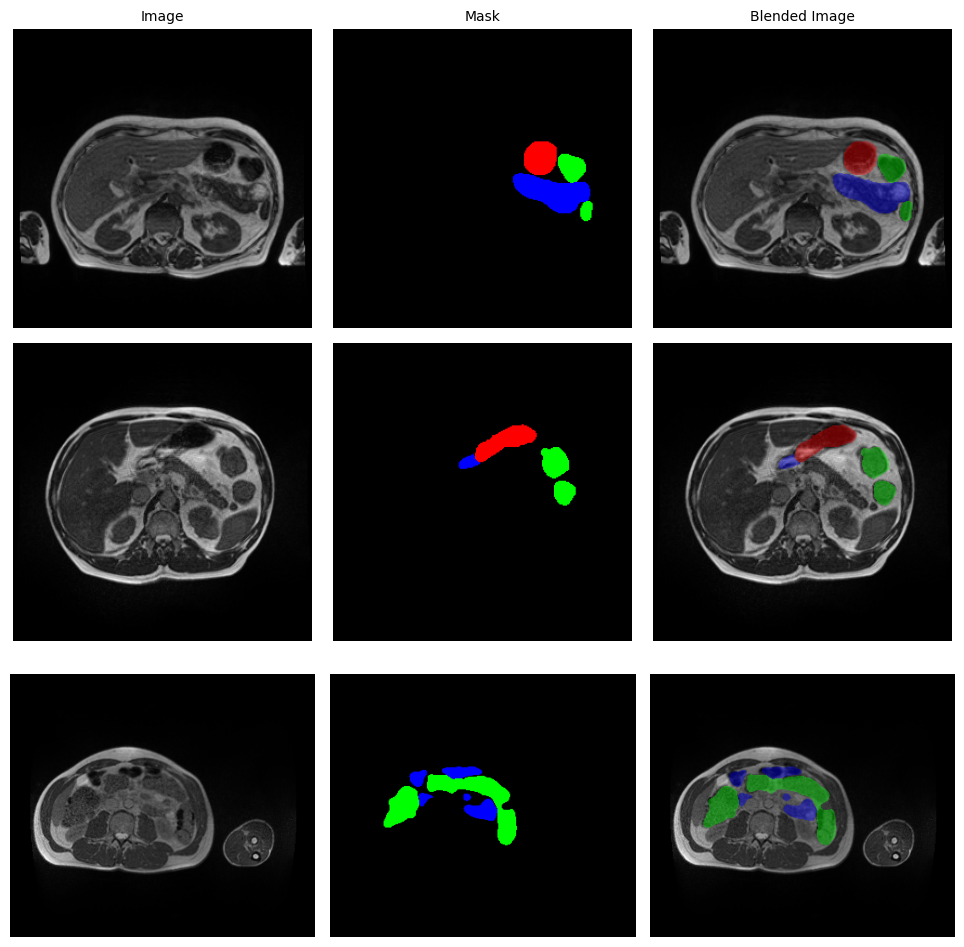

In [30]:
plot_image_masks(df_data[df_data.split == "train"])